In [1]:
import csv
import pandas as pd
import math
import numpy as np
import datetime
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

In [2]:
def showProgressPercentage(current, total) : 
    prevPercentage = int ((current-1) / total * 100)
    currPrecentage = int (current / total * 100)
    progress = 0
    if (currPrecentage >= 90 and prevPercentage < 90) : 
        progress = 90
    elif (currPrecentage >= 80 and prevPercentage < 80) : 
        progress = 80 
    elif (currPrecentage >= 70 and prevPercentage < 70) : 
        progress = 70 
    elif (currPrecentage >= 60 and prevPercentage < 60) : 
        progress = 60 
    elif (currPrecentage >= 50 and prevPercentage < 50) : 
        progress = 50 
    elif (currPrecentage >= 40 and prevPercentage < 40) : 
        progress = 40 
    elif (currPrecentage >= 30 and prevPercentage < 30) : 
        progress = 30 
    elif (currPrecentage >= 20 and prevPercentage < 20) : 
        progress = 20 
    elif (currPrecentage >= 10 and prevPercentage < 10) : 
        progress = 10 
    if (progress > 0) :
        print(progress, "%")
        
def mapDayToNumber(day) :
    dayOfWeeks = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
    for i in range(len(dayOfWeeks)) : 
        if (dayOfWeeks[i] == day) : 
            return i+1
    return 0
def mapTimeToNumber(time) :
    times = ["12AM", "01AM", "02AM", "03AM", "04AM", "05AM", "06AM", "07AM", "08AM", "09AM", "10AM", "11AM", "12PM", "01PM", "02PM", "03PM", "04PM", "05PM", "06PM", "07PM", "08PM", "09PM", "10PM", "11PM"]
    for i in range(len(times)) : 
        if (times[i] == time) : 
            return i
    return 0
    
def fetchDay(createTime)  :
    [dayOfWeek, time] = createTime.split(' ')
    return mapDayToNumber(dayOfWeek)

def fetchTime(createTime) : 
    [dayOfWeek, time] = createTime.split(' ')
    return mapTimeToNumber(time)

def correctThePrice(oldPrice) : 
    newPrice = oldPrice
    if (4500 < oldPrice < 10000) : 
        newPrice = -11
#         newPrice = oldPrice * 10
    
    elif (10 <= oldPrice <= 4500) : 
        newPrice = oldPrice * 1000
        
    elif (0 < oldPrice < 10) : 
        newPrice = -11
#         newPrice = oldPrice * 1000000
    
    return newPrice

def getAveragePricesPerBrands(df, brands) : 
    sums = { i : 0 for i in brands }
    repeats = { i : 0 for i in brands }
    avgs = { i : 0 for i in brands }
    for index, dfRow in df.iterrows() :
        price = dfRow['price']
        if (price != -1) : 
            sums[dfRow['brand']] += price
            repeats[dfRow['brand']] += 1
    for brand in brands : 
        avgs[brand] = int(sums[brand] / repeats[brand])
    return [avgs, repeats]
        
    

In [3]:
def getProcessedNonTextData(dataFile, brandEncType = "onehot", cityEncType = "onehot") : 
    data = []
    valData = []
    targetData = []
    col_list = ["brand", "city", "title", "desc", "image_count", "created_at", "price"]
    df = pd.read_csv(dataFile, usecols=col_list)
    
    print("preprocessing started...")
    
    if (brandEncType == "onehot") :
        df = pd.concat([df,pd.get_dummies(df['brand'], prefix = "brand")],axis=1)
    
    print("brand onehot encoding done...")
        
    if (cityEncType == "onehot") :
        df = pd.concat([df,pd.get_dummies(df['city'], prefix = "city")],axis=1)
        
    print("city onehot encoding done...")
    
    df['dayOfweek'] = df.apply(lambda row : fetchDay(row['created_at']), axis = 1) 
    df['time'] = df.apply(lambda row : fetchTime(row['created_at']), axis = 1) 
    del df['created_at']
    
    print("time preprocessing done...")
    
    df['price'] = df.apply(lambda row : correctThePrice(row['price']), axis = 1)
    df = df.loc[df['price'] > -10]
    
    brands = df.brand.unique()
    [avgPrices, rep] = getAveragePricesPerBrands(df, brands)
    print(rep)
    
    print("price correction done, average price per every brand calculated...")
    
    for index, dfRow in df.iterrows() :
        price = dfRow['price']
        if (price == -1) : 
            price = avgPrices[dfRow['brand']]
        targetData.append(price)
        del dfRow['price']
        del dfRow['brand']
        del dfRow['city']  
        data.append(dfRow)
    
    for index, dfRow in df.iterrows() :
        price = dfRow['price']
        if (price == -1) : 
            price = avgPrices[dfRow['brand']]
        del dfRow['price']
        del dfRow['brand']
        del dfRow['city']  
        del dfRow['title']
        del dfRow['desc']
        valData.append(dfRow)
        
    
    labels = list(df)
    labels.remove('price')
    labels.remove('brand')
    labels.remove('city')
    valLabels = list(df)
    valLabels.remove('price')
    valLabels.remove('brand')
    valLabels.remove('city')
    valLabels.remove('title')
    valLabels.remove('desc')
    
    print("part1 done.")
    return [df, data, valData, targetData, labels, valLabels]

In [4]:
[df, data, valData, targetData, labels, valLabels] = getProcessedNonTextData("mobile_phone_dataset.csv")

preprocessing started...
brand onehot encoding done...
city onehot encoding done...
time preprocessing done...
{'Nokia::نوکیا': 3512, 'Apple::اپل': 13796, 'Samsung::سامسونگ': 18041, 'Huawei::هوآوی': 6627, 'LG::ال\u200cجی': 2278, 'ZTE::زدتی\u200cای': 1539, 'Sony::سونی': 3830, 'HTC::اچ\u200cتی\u200cسی': 2647, 'Lenovo::لنوو': 1007}
price correction done, average price per every brand calculated...
part1 done.


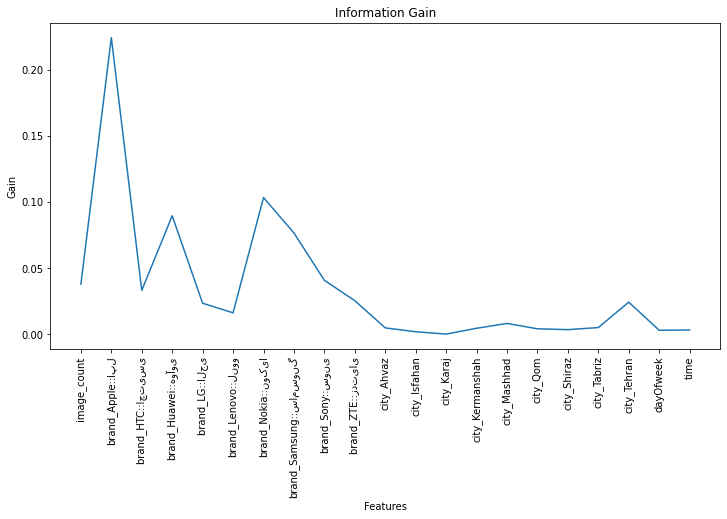

In [5]:
informationGains = mutual_info_classif(valData, targetData)
def showInformationGains(labels) :
    plt.figure(figsize=(12, 6))
    plt.plot(informationGains) 
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.xlabel('Features') 
    plt.ylabel('Gain') 
    plt.title('Information Gain') 

    plt.show()
showInformationGains(valLabels)

In [6]:
import hazm
from hazm.WordTokenizer import WordTokenizer
from nltk.corpus import stopwords 
from hazm.Lemmatizer import Lemmatizer
from hazm.Normalizer import Normalizer
import operator

stop_words_fa = set(hazm.utils.stopwords_list()) 
stop_words_en = set(stopwords.words('english')) 
punctuations = {",", ".", "(", ")", ";", ":", "؛", "،"}
bulshits = {"معاوضه", "تی", "n", "کارت", "رنگ", "se", "تعویض", "ساده", "لا", "حتما", "پرید#پر", "فروشی", "بخونید", "عدد", "قیمت", "داره", "تخفیف", "هست", "داشت#دار", "سلام", "تماس", "فروش", "میدم", "یه", "نداره", "خریدار", "لطفا", "مقطوع", "شرط", "خرید#خر", "کارتن", "میباشد", "تشکر", "میکنم", "العاده", "عدد", "ممنون", "فوری", "خودم", "عکس", "دی", "-", "معامله", "کارتون", "پیامک", "مشتری", "هستش", "جواب", "هفته", "پای", "جانبی", "میشه", "زنگ", "تومن", "باتشکر", "اصلا", "کرد#کن", "باسلام", "فروخت#فروش", "مگاپیکسل", "میخوام", "مهلت", "میشود", "ب", "یاعلی", "اگه", "گذاشت#گذار", "واقعا", "تومان", "باشه"}
stop_words = stop_words_fa.union(stop_words_en)
stop_words = stop_words.union(punctuations)
stop_words = stop_words.union(bulshits)

normalizer = Normalizer()
tokenizer = WordTokenizer()
lemmatizer = Lemmatizer()
# print(stop_words)

def lowerAllCharacters(context) :
    context = context.lower()
    return context

def normalizeContext(context) : 
    context = normalizer.affix_spacing(context)
    context = normalizer.character_refinement(context)
    context = normalizer.punctuation_spacing(context)
    return context

def removeStopWordsAndPunctuations(context) : 
#     tokenizer = RegexpTokenizer(r'\w+')
    context = tokenizer.tokenize(context)
    
    filtered_sentence = [] 
    
    for w in context: 
        if w not in stop_words: 
            filtered_sentence.append(w)
    return filtered_sentence

def lemmatizeWords(wordList) : 
    for i in range(len(wordList)):
        wordList[i] = lemmatizer.lemmatize(wordList[i])
            
    return wordList

def finalStopCheck(wordList) : 
    filtered_sentence = [] 
    
    for w in wordList: 
        if w not in stop_words: 
            filtered_sentence.append(w)
    return filtered_sentence

def getProcessedWords(context) : 
    context = lowerAllCharacters(context)
    context = normalizeContext(context)
#     wordList = []
    wordList = removeStopWordsAndPunctuations(context)
    wordList = lemmatizeWords(wordList)
    wordList = finalStopCheck(wordList)
    return wordList

    

In [7]:
def getProcessedTextData(data, rowName) : 
    totalWords = {}
    wordLists = []
    for row in data :
        wordList = getProcessedWords(row[rowName])
        wordLists.append(wordList)
        for word in wordList : 
            if word in totalWords : 
                totalWords[word] += 1
            else :
                totalWords[word] = 1
#         print(i)
#         print(row['title'])
#         print(wordList)
#         print("_____________________________________________________")
    return [wordLists, totalWords]

In [8]:
[titleWordLists, totalTitleWords] = getProcessedTextData(data, 'title')

In [9]:
[descWordLists, totalDescWords] = getProcessedTextData(data, 'desc')

In [10]:
sortedTitleWords = sorted(totalTitleWords.items(),key=operator.itemgetter(1),reverse=True)
sortedDescWords = sorted(totalDescWords.items(),key=operator.itemgetter(1),reverse=True)
print(sortedTitleWords)
print(sortedDescWords)
# idx = 0 #150
# for i in sortedTitleWords :
#     idx += 1
#     print(idx, i)

# idx = 0 #100
# for i in sortedDescWords :
#     idx += 1
#     print(idx, i)


[('گوش', 18243), ('سامسونگ', 8649), ('موبایل', 5057), ('g', 3577), ('iphone', 3308), ('۱۶', 3083), ('هواوی', 3002), ('ایفون', 2946), ('گیگ', 2844), ('۶۴', 2836), ('نوکیا', 2719), ('نو', 2698), ('۵s', 2696), ('جی', 2610), ('سون', 2556), ('اپل', 2441), ('۶', 2345), ('۳۲', 2343), ('آیفون', 2312), ('گلکسی', 2238), ('اس', 2076), ('تمیز', 1978), ('htc', 1761), ('۶s', 1759), ('۵', 1684), ('گلد', 1340), ('gb', 1309), ('ال', 1260), ('سالم', 1247), ('gold', 1227), ('مدل', 1199), ('۲۰۱۶', 1193), ('samsung', 1106), ('gig', 1092), ('galaxy', 1081), ('۴', 1043), ('هوآوی', 907), ('مشک', 895), ('۴g', 877), ('اصل', 868), ('دوسیم', 863), ('lg', 823), ('۳', 818), ('سفید', 797), ('s۶', 786), ('سیم', 785), ('اچ', 768), ('اک', 757), ('۲', 751), ('۴s', 735), ('apple', 732), ('sony', 722), ('huawei', 720), ('٦', 712), ('آک', 691), ('پلاس', 658), ('s۵', 636), ('فورجی', 627), ('۶۱۰', 622), ('١٦', 619), ('گرند', 614), ('s۴', 610), ('j۷', 605), ('gray', 605), ('edge', 604), ('s۳', 591), ('plus', 585), ('٦٤', 567)

In [11]:
handedFeatures = {"آیفون", "ایفون", "apple", "اپل", "iphone", "samsung", "سامسونگ", "galaxy", "گلکسی", "nokia", "نوکیا", "huawei", "هوآوی", "هواوی", "lg", "الجی", "zte", "sony", "سونی", "htc", "اچ_تی_سی", "lenovo", "لنوو"}
def getImpWords(wordList, amount) : 
    words = set()
    i = 0
    for word in wordList :
        if (i >= amount) : 
            break
        words.add(word[0])
        i += 1
    words = words.union(handedFeatures)
    return words

In [12]:
titleImpWords = getImpWords(sortedTitleWords, 200)
descImpWords = getImpWords(sortedDescWords, 200)
# print(len(titleImpWords))
# print(len(descImpWords))

In [13]:
# print(titleImpWords)
# print(descImpWords)
def checkFeature(i, feature, wordList, bias) : 
    if (feature in wordList[i]) : 
        return bias
    return 0

In [14]:
def rowIndex(row):
    return row.name
def addFeatures(prefix, df, impWords, wordLists, bias=1) :
    i = 0
    totalSize = len(impWords)
    df["rowIndex"] = list(range(len(df)))
    for feature in impWords : 
        df[prefix + feature] = df.apply(lambda row : checkFeature(row['rowIndex'], feature, wordLists, bias), axis = 1) 
        i += 1
        showProgressPercentage(i, totalSize)
    return df

In [15]:
df2 = addFeatures("title_", df, titleImpWords, titleWordLists, 1)

10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %


In [16]:
df2 = addFeatures("desc_", df, descImpWords, descWordLists, 1)

10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %


In [17]:
def getDatas(df) :
    data = []
    targetData = []
    brands = df.brand.unique()
    [avgPrices, repeats] = getAveragePricesPerBrands(df, brands)
    
    for index, dfRow in df.iterrows() :
        price = dfRow['price']
        if (price == -1) : 
            price = avgPrices[dfRow['brand']]
        targetData.append(price)
#         print(dfRow["desc_lla"])
        del dfRow['price']
        del dfRow['brand']
        del dfRow['city']
        del dfRow['title']
        del dfRow['desc']
        data.append(dfRow)
    
    labels = list(df)
    labels.remove('price')
    labels.remove('brand')
    labels.remove('city')
    labels.remove('title')
    labels.remove('desc')
    print("preprocessing done.")
    return [df, data, targetData, labels]

In [18]:
[df2, data2, targetData2, labels2] = getDatas(df)

preprocessing done.


In [19]:
data2

[image_count            2
 brand_Apple::اپل       0
 brand_HTC::اچ‌تی‌سی    0
 brand_Huawei::هوآوی    0
 brand_LG::ال‌جی        0
                       ..
 desc_یکم               0
 desc_نقطه              0
 desc_۶s                0
 desc_شکسته             0
 desc_#هست              0
 Name: 0, Length: 442, dtype: object,
 image_count            0
 brand_Apple::اپل       1
 brand_HTC::اچ‌تی‌سی    0
 brand_Huawei::هوآوی    0
 brand_LG::ال‌جی        0
                       ..
 desc_یکم               0
 desc_نقطه              0
 desc_۶s                0
 desc_شکسته             0
 desc_#هست              0
 Name: 1, Length: 442, dtype: object,
 image_count            2
 brand_Apple::اپل       0
 brand_HTC::اچ‌تی‌سی    0
 brand_Huawei::هوآوی    0
 brand_LG::ال‌جی        0
                       ..
 desc_یکم               0
 desc_نقطه              0
 desc_۶s                0
 desc_شکسته             0
 desc_#هست              0
 Name: 2, Length: 442, dtype: object,
 image_count            3
 b

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression

trainData, testData, trainTarget, testTarget = train_test_split(data2, targetData2, test_size=0.20)

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
import lightgbm

def doLinearRegression() : 
    linearTestPredic = []
    linearTrainPredic = []
    
    clf = LinearRegression()
    clf.fit(trainData, trainTarget)
    
    linearTestPredic = clf.predict(testData)
       
    linearTrainPredic = clf.predict(trainData)
        
    return [linearTrainPredic, linearTestPredic]

def doRandomForest(d, n_est = 3, features = 0.5) : 
    rfTestPredic = []
    rfTrainPredic = []
    
    regr = RandomForestRegressor(max_depth=d, random_state=0, n_estimators=n_est, max_features=features, max_samples=features)
    regr.fit(trainData, trainTarget)
    
    rfTestPredic = regr.predict(testData)
       
    rfTrainPredic = regr.predict(trainData)
        
    return [rfTrainPredic, rfTestPredic]

def doRidgeRegression(alp = 1.0) : 
    rgTestPredic = []
    rgTrainPredic = []
    
    regr = Ridge(alpha=alp)
    regr.fit(trainData, trainTarget)
    
    rgTestPredic = regr.predict(testData)
       
    rgTrainPredic = regr.predict(trainData)
        
    return [rgTrainPredic, rgTestPredic]

def doSVRegression(cc = 1.0, eps = 0.2) : 
    svrTestPredic = []
    svrTrainPredic = []
    
    regr = SVR(C=cc, epsilon=eps)
    regr.fit(trainData, trainTarget)
    
    svrTestPredic = regr.predict(testData)
       
    svrTrainPredic = regr.predict(trainData)
        
    return [svrTrainPredic, svrTestPredic]

def doLGBMegression(lv = 100, lr = 0.5, n_est = 100) : 
    lgbmTestPredic = []
    lgbmTrainPredic = []
    
    regr = lightgbm.LGBMRegressor(num_leaves=lv, learning_rate=lr, n_estimators=n_est)
    regr.fit(trainData, trainTarget)
    
    lgbmTestPredic = regr.predict(testData)
       
    lgbmTrainPredic = regr.predict(trainData)
        
    return [lgbmTrainPredic, lgbmTestPredic]

In [22]:
def printModelInfo(predicts, realValues) : 
    trainMSE = mean_squared_error(realValues[0], predicts[0], squared=False)
    testMSE = mean_squared_error(realValues[1], predicts[1], squared=False)
    print(trainMSE)
    print(testMSE)

    trainMAE = mean_absolute_error(realValues[0], predicts[0])
    testMAE = mean_absolute_error(realValues[1], predicts[1])
    print(trainMAE)
    print(trainMAE)

In [23]:
linearPredicts = doLinearRegression()
printModelInfo(linearPredicts, [trainTarget, testTarget])

304262.1794535903
309686.81486484053
214618.46569643688
214618.46569643688


In [24]:
rfPredicts = doRandomForest(20, 100, 0.4)
printModelInfo(rfPredicts, [trainTarget, testTarget])

263763.4115023482
295082.8425143454
184385.3575876303
184385.3575876303


In [43]:
rgPredicts = doRidgeRegression(1)
printModelInfo(rgPredicts, [trainTarget, testTarget])

301440.0584813446
306722.3307374884
211099.505783459
211099.505783459


In [41]:
lgbmPredicts = doLGBMegression(120, 0.09, 100)
printModelInfo(lgbmPredicts, [trainTarget, testTarget])

242294.96177213453
277991.7142527974
164374.42062335368
164374.42062335368
